In [366]:
import torch
import numpy as np
import math
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import r2_score
import matplotlib as mpl
import os
import gc
import pandas as pd
import csv
from numpy import *
from torch.utils.tensorboard import SummaryWriter
from datetime import date
import random
from sklearn.model_selection import KFold
import os


In [367]:
prob = np.random.dirichlet(np.ones(5),size=1)
print(prob)
print(np.sum(prob))

[[0.20972379 0.0009453  0.21525627 0.55952358 0.01455105]]
1.0


1) A, B,C, D, E are the five qualitative variable which occur in a primary sequence. 0-A, 1-B, 2-C, 3-D, 4-E, 5-X

In [368]:
## different amino acids
# amino_acid = ['A','B','C','D','E','X'] # X is the uncommon amino acid, so total length is 6
amino_acid = ['A','B','C','D','E'] # X is the uncommon amino acid, so total length is 5
aa_prop = [5,2,4,1,8]
print('Number of unique amino acids are', np.shape(np.unique(amino_acid))[0])

def onehotseq(sequence):
  seq_len = len(sequence)
  seq_en = np.zeros(( seq_len, np.shape(amino_acid)[0]))
  for i in range(seq_len):
      seq_en[i,sequence[i]] = 1
  return seq_en

Number of unique amino acids are 5


**All Dataset**

In [369]:
N=1200
L=50
m_l = 1
motif_length = 3
creating_example = np.zeros((N,L), dtype=int) #np.random.randint(0,5, (N,L), dtype=int)
seq_length = np.ones((N,), dtype=int)*L
prop = np.zeros((N,L))

## creating the primary sequence
for i in range(N):
    j = 0
    while j <= (L-m_l):
        # choose_aa = random.choices([0,1,2,3,4,5], \
        #     weights=[0.18,0.18,0.18,0.18,0.18,0.1], k=1)[0]
        choose_aa = random.choices([0,1,2,3,4], \
            weights=[0.2,0.2,0.2,0.2,0.2], k=1)[0]
        creating_example[i,j:j+m_l] = int(choose_aa)
        j += 1

## assigning values at which pos
for i in range(N):
    j = 1
    while j < (L-1):     
        if 5 not in creating_example[i,j-1:j+2]:
            local = [ aa_prop[creating_example[i,k]] for k in range(j-1, j+2)]
            prop[i, j] = (local[0] + local[1])*local[2]
        j += 1

output_seq = prop
output_y = np.sum(prop, axis=1)

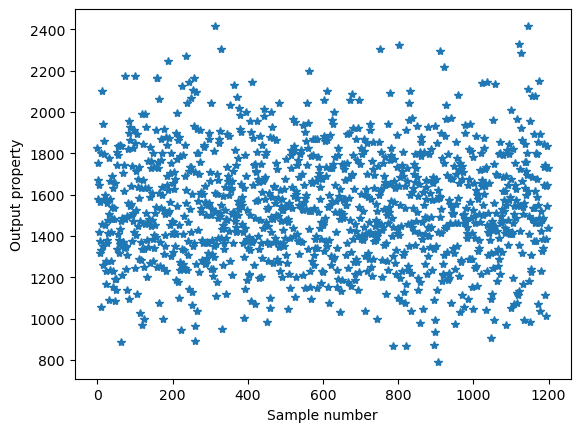

In [370]:
ohe = np.zeros((creating_example.shape[0], creating_example.shape[1], len(amino_acid)))
for i in range(ohe.shape[0]): 
    l = seq_length[i]
    ohe[i,0:l,:] = onehotseq(creating_example[i,0:l])

plt.plot(output_y, '*')
plt.ylabel('Output property')
plt.xlabel('Sample number')
plt.show()

Mean: 1537.9875
Standard Deviation: 267.68365784463447
Variance: 71654.54067708334


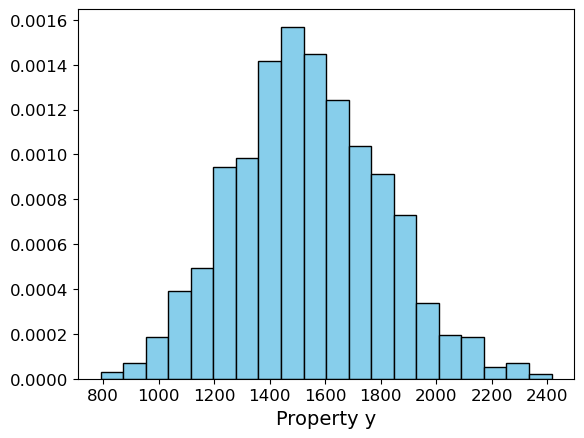

In [371]:
print('Mean:', np.mean(output_y))
print('Standard Deviation:', np.std(output_y))
print('Variance:', np.var(output_y))

plt.hist(output_y, bins=20, color='skyblue', edgecolor='black', density=True)
plt.xlabel('Property y', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

**Mean Preserving Methods for Adding Aleatoric Noise with Non-Uniform Spread**

In [ ]:
#Base:
# noisy_output_y = output_y
# std_dev = np.zeros(len(noisy_output_y))
# variance = np.zeros(len(noisy_output_y))

# MODEL 1: linear transformation, normally distributed spread
# slope = 0.1
# intercept = 100
# std_dev = (slope * output_y + intercept)
# noisy_output_y =  np.random.normal(output_y, std_dev, output_y.shape)
# variance = std_dev**2

## MODEL 2: polynomial noise, normally distributed spread
# polynomial_coeff = 0.0002
# std_dev = polynomial_coeff * output_y**2
# noisy_output_y =  np.random.normal(output_y, std_dev, output_y.shape)
# variance = std_dev**2

## MODEL 3: sinusoidal noise, normally distributed spread
# amplitude = .2
# frequency = 2 * np.pi
# indices = np.arange(output_y.shape[0])
# std_dev = abs(amplitude * output_y * np.sin(frequency * indices / output_y.shape))
# noisy_output_y =  np.random.normal(output_y, std_dev, output_y.shape)
# variance = std_dev**2

                     Original Output      Noisy Output        
------------------------------------------------------------
Mean:                1537.9875            1531.2728           
Standard Deviation:  267.6837             358.7243            
Variance:            71654.5407           128683.1024         


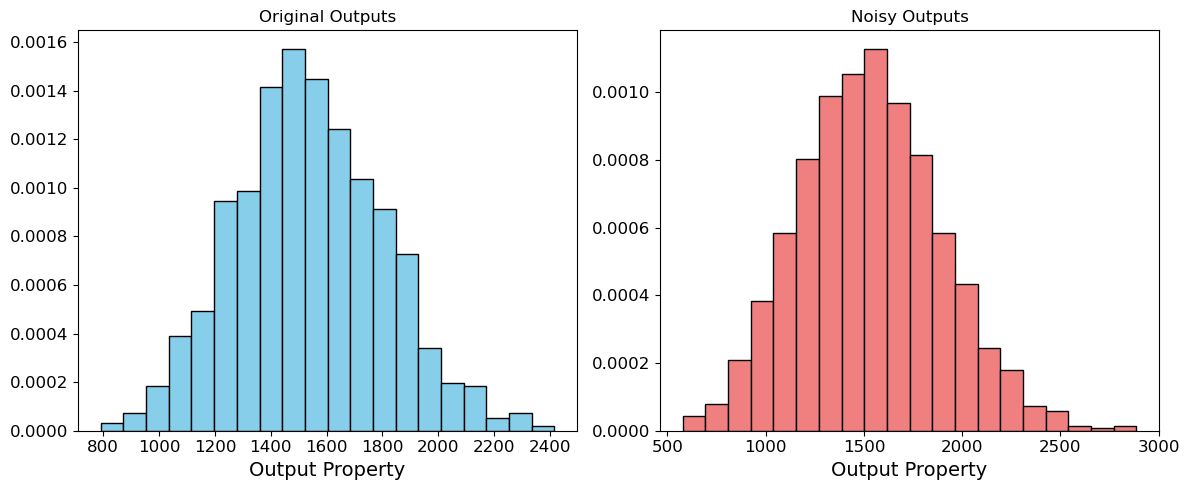

In [373]:
print(f"{'':<20} {'Original Output':<20} {'Noisy Output':<20}")
print(f"{'-'*60}")
print(f"{'Mean:':<20} {np.mean(output_y):<20.4f} {np.mean(noisy_output_y):<20.4f}")
print(f"{'Standard Deviation:':<20} {np.std(output_y):<20.4f} {np.std(noisy_output_y):<20.4f}")
print(f"{'Variance:':<20} {np.var(output_y):<20.4f} {np.var(noisy_output_y):<20.4f}")

# Plots for Variance & Standard Deviation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# First subplot: Standard Deviation
ax1.set_title('Original Outputs')
ax1.hist(output_y, bins=20, color='skyblue', edgecolor='black', density=True)
ax1.set_xlabel('Output Property', fontsize=14)
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
# Second subplot: Normalized Actual vs Predicted Variance
ax2.set_title('Noisy Outputs')
ax2.hist(noisy_output_y, bins=20, color='lightcoral', edgecolor='black', density=True)
ax2.set_xlabel('Output Property', fontsize=14)
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
plt.tight_layout()
plt.show()

Avg. Variance: 65130.350908333334
Standard Deviation: 253.79875


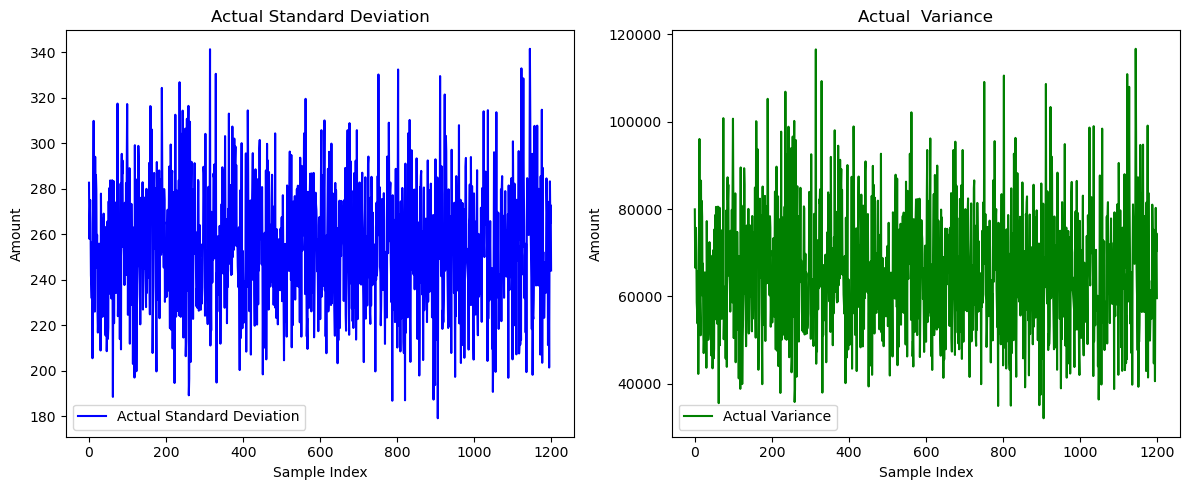

In [374]:
print('Avg. Variance:', np.mean(variance))
print('Standard Deviation:', np.mean(std_dev))

# Plots for Variance & Standard Deviation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# First subplot: Standard Deviation
ax1.plot(range(len(std_dev)), std_dev, 'b-', label='Actual Standard Deviation')
ax1.set_title('Actual Standard Deviation')
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('Amount')
ax1.legend()
# Second subplot: Normalized Actual vs Predicted Variance
ax2.plot(range(len(variance)), variance, 'g-', label='Actual Variance')
ax2.set_title('Actual  Variance')
ax2.set_xlabel('Sample Index')
ax2.set_ylabel('Amount')
ax2.legend()
plt.tight_layout()
plt.show()

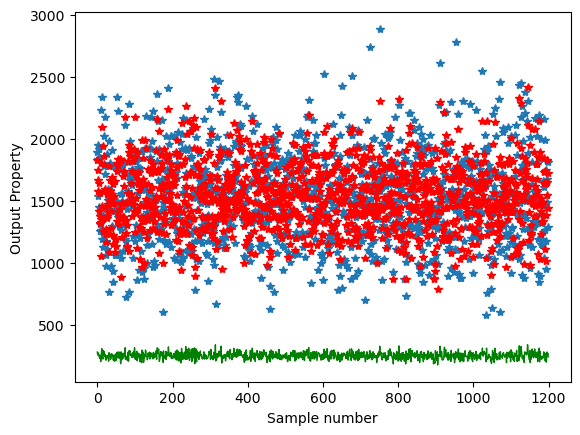

In [375]:
plt.plot(noisy_output_y, '*')
plt.plot(output_y, '*', color = 'red')
plt.plot(std_dev, label='New Noise $z(x)$', color='green', linewidth=1)
plt.ylabel('Output Property')
plt.xlabel('Sample number')
plt.show()

**Divide Dataset**

In [376]:
all_ex = np.arange(ohe.shape[0])
X, x_test, _, _ = train_test_split( all_ex, all_ex, test_size=0.083333,random_state=10)
x_train, x_valid, _, _ = train_test_split( X, X, test_size=0.0909,random_state=10)

print('Train',x_train.shape)
print('Test' ,x_test.shape)
print('Valid',x_valid.shape)

Train (1000,)
Test (100,)
Valid (100,)


In [377]:
# Metrics for training
print('Avg. Variance Train:', np.mean(variance[x_train]))
print('Standard Deviation Train:', np.sqrt(np.mean(variance[x_train])))
print()
# Metrics for validation set that's printed in training model
print('Avg. Variance:', np.mean(variance[x_valid]))
print('Standard Deviation:', np.sqrt(np.mean(variance[x_valid])))

Avg. Variance Train: 65175.71647000001
Standard Deviation Train: 255.29535144612407

Avg. Variance: 64552.42580000001
Standard Deviation: 254.07169421248014


In [378]:
if not os.path.exists('./datasets'):
    os.makedirs('./datasets')

np.save('./datasets/x_train', ohe[x_train])
np.save('./datasets/len_train', seq_length[x_train])
# np.save('./datasets/y_train', output_y[x_train]) # Base Case Only
np.save('./datasets/y_train', noisy_output_y[x_train])
np.save('./datasets/s2_train', variance[x_train])

np.save('./datasets/x_valid', ohe[x_valid])
np.save('./datasets/len_valid', seq_length[x_valid])
np.save('./datasets/y_valid', output_y[x_valid])
np.save('./datasets/s2_valid', variance[x_valid])

np.save('./datasets/x_test', ohe[x_test])
np.save('./datasets/len_test', seq_length[x_test])
np.save('./datasets/y_test', output_y[x_test])
np.save('./datasets/s2_test', variance[x_test])

**Datasets for Cross Validation**

In [379]:
k_folds = 11
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

if not os.path.exists('./folds'):
    os.makedirs('./folds')

# Generate folds
for fold, (train_ids, val_ids) in enumerate(kfold.split(X)):
    # Further split training data to get validation set
    train_indices = train_ids
    valid_indices = val_ids
    
    # Save training data
    np.save(f'./folds/x_train_fold_{fold}', ohe[train_indices])
    np.save(f'./folds/len_train_fold_{fold}', seq_length[train_indices])
    np.save(f'./folds/y_train_fold_{fold}', noisy_output_y[train_indices])
    np.save(f'./folds/s2_train_fold_{fold}', variance[train_indices])
    
    # Save validation data
    np.save(f'./folds/x_valid_fold_{fold}', ohe[valid_indices])
    np.save(f'./folds/len_valid_fold_{fold}', seq_length[valid_indices])
    np.save(f'./folds/y_valid_fold_{fold}', output_y[valid_indices])
    np.save(f'./folds/s2_valid_fold_{fold}', variance[valid_indices])